# Candidate problem
***
This notebook contains the main steps to solve the candidate problem for Univers Solar Advanced Analytics. The current notebook is divided as follows:
1. **Import main libraries and internally-developed functions**
2. **Read and visualize data set**
3. **Get AC power expected**
4. **Model daily Soiling Ratio**
5. **Answer to the problem**
 

## 1. Import main libraries and internally-developed functions

### Import general libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_style("whitegrid")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from datetime import datetime
import sys
import os
import warnings
warnings.filterwarnings('ignore')

### Import internally-developed functions

In [2]:
sys.path.append('D:/repo/Envision_Digital/test/test_2')  # Path to the functions
# import tools
from source import tools, pv_functions, soiling

## 2. Read and visualize data set 

### Read Data
***
Get the data from teh .csv file

In [3]:
# Usage
data_file = r'D:\repo\Envision_Digital\test\test_2\data\data_input.csv'

if os.path.isfile(data_file):
    data_df = tools.read_data(data_file)
    print("Data loaded successfully.")
else:
    print(f"File not found: {data_file}")

# Get the usefull columns
data_df = data_df[['wind_speed', 'tmp_amb', 'poa', 'tmp_cell','ac_power','rain_mm']]

Data loaded successfully.


### Data visualization
***

Make sure that the data is well loaded and in sync

In [4]:
# Define the date for which you want to plot data
target_date = '2021-07-18'  # visualizing only one day

# Filter the DataFrame to include data for the target date
one_day_df = data_df[data_df.index.date == pd.to_datetime(target_date).date()]

# Create a figure with two subplots, sharing the x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the first scatter plot for 'poa' on the first subplot
fig.add_trace(go.Scatter(x=one_day_df.index, y=one_day_df['poa'], name='POA'), row=1, col=1)

# Add the second scatter plot for 'ac_power' on the second subplot
fig.add_trace(go.Scatter(x=one_day_df.index, y=one_day_df['ac_power'], name='AC Power'), row=2, col=1)

# Set the axis labels
fig.update_xaxes(title_text='Time', row=2, col=1)
fig.update_yaxes(title_text='Irradiance POA [W/m^2]', row=1, col=1)
fig.update_yaxes(title_text='AC Power [W]', row=2, col=1)

# Set the title for the whole figure
fig.update_layout(title_text=f'POA and AC Power for {target_date}')

fig.show()

## 3. Get AC power expected
***
Expected AC Power = DC-AC Inverter Efficiency * DC Power Rating / G * POA Irradiance * ( 1 – Module temperature coefficient *
(Reference Temperature - Cell temperature) )

    *where G = 1000 W/m^2 and Reference temperature = 25 deg C

In [5]:
# Dataset associated parameters
constants = {
    'Mcoef': -0.0045, # (deg C^-1)
    'DC_P': 80000,  # W
    'AC_P': 70000,  # W
    'Tilt': 15,  # deg
    'Azimuth': 180,  # deg
    'DC_AC_n': 1,  # 100%
    'G': 1000,  # W/m^2
    'Tcell_ref': 25,  # deg C
}

weather_columns = {
    'poa': 'poa',
    'tmp_cell': 'tmp_cell',
    # Add more columns as needed.
}

data_df = pv_functions.calculate_expected_power(data_df, constants, weather_columns)
print('AC Expected power calculated')

AC Expected power calculated


### Visualizing expected values


In [6]:
# Filter the DataFrame to include data for the target date
one_day_df = data_df[data_df.index.date == pd.to_datetime(target_date).date()]
fig = px.scatter(one_day_df, x=one_day_df.index, y='AC_Power_exp', labels={'AC_Power_exp': 'AC Power expected'})
fig.add_scatter(x=one_day_df.index, y=one_day_df['ac_power'], mode='lines+markers', name='AC Power Measured')
# Set the axis labels
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='AC Power [W]')

fig.update_layout(title=f'Power Comparison {target_date}')
fig.show()

## 4. Model Daily Soiling Rate
***
### 4a. Calculate Instantaneous Soiling Ratio

This function computes the Instantaneous Soiling Ratio (SRatio) based on provided data and applies various filters according to https://doi.org/10.1016/j.energy.2022.123173. The SRatio represents the deposition of soiling on solar panels and is computed as the ratio of the actual AC power measured to the reference AC power (measured) under clean conditions (expected conditions-calculated).

#### Calculation of SRatio

The SRatio is calculated as:

$$\text{SRatio} = \frac{\text{AC Power Measured}}{\text{AC Power Reference}}$$


#### Filters Applied

The function applies three filters to the data to select the data with quality under certain conditions according to the publication:

1. **Time of Day Filter**: This filter restricts the data to a specific time range between 11 a.m. and 1 p.m. Focus on data collected during periods with the most significant solar irradiance.

2. **Irradiance Threshold Filter**: Data points with Global Plane of Array Irradiance (GPOA) less than 700 W/m² are excluded from the calculation. This step is taken to reduce noise in the soiling extraction process and focus on data collected under sufficient irradiance.

3. **Two-Sigma Filter**: The function calculates the mean $(\mu)$ and standard deviation $(\sigma)$ of the SRatio based on the data points that passed the previous filters. Then, it filters the SRatio data to retain values within two standard deviations from the mean:

$$
\text{SRatio} \in [\mu - 2\sigma, \mu + 2\sigma]
$$

The two-sigma filter helps remove outliers and data points that deviate significantly from the typical SRatio values.

#### Output

The function returns a filtered DataFrame containing SRatio values that have passed all applied filters.

#### Usage Example

filtered_df = instantaneous_soiling_ratio(df_rate)


In [7]:
df_rate = soiling.instantaneous_soiling_ratio(data_df)
fig= px.scatter(df_rate, x=df_rate.index, y='S_ratio')
# Set the axis labels
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Instantaneous soiling rate')

fig.update_layout(title=f'Soiling Rate')
fig.show()

***
### 4b. Calculate the daily soiling rate

Daily soiling rate calculation and visualization. The function gets the mean of the intantaneous soiling rate values.

Text(0, 0.5, 'Rain [mm]')

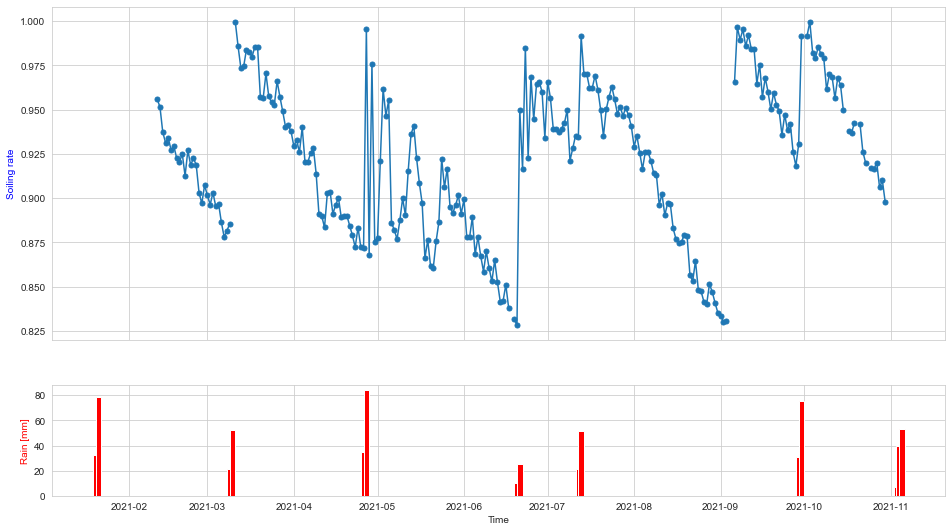

In [8]:
daily_rate = soiling.calculate_daily_soiling_rate(df_rate)
daily_rain = data_df.rain_mm.resample('D').mean()
daily_rain = daily_rain[daily_rain>0]
x = daily_rate.index
x2 = daily_rain.index
fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
axs[0].plot(x, daily_rate.S_ratio, marker = '.', markersize = 10)
axs[1].bar(x=x2, height=daily_rain, color='red', width=2)
axs[1].set_xlabel('Time')
axs[0].set_ylabel('Soiling rate', color='b')
axs[1].set_ylabel('Rain [mm]', color='red')

## 5. Answer to the problem
***
### A. Module soiling rate (%/day) for the year --- a single value!

To model a single value we can do it in 2 different ways according to my point of view.
1. Statistical approach
2. Regression approach (this method wont be implemented here due to time shortage. However, if we consider values of daily soiling rate between rain events, a linear interpolation can be done and a rate of change can be calculated which will be considered the daily rate for all those events. A mean value can be calculated among the different trends between the rain events)


#### a: Statistical approach

1. We can get the negative differences between the daily soiling rate (green plot), which basically represent the change from one day to the next one (only negative changes should be considered = red plot).
2. After we got this first step, then we can calculate the average value of the absolute changing rate an consider this as a yearly value. I consider only values in the 90% quantile. This has been represented by the histogram below.

Text(0, 0.5, 'Only negative Difference [%]')

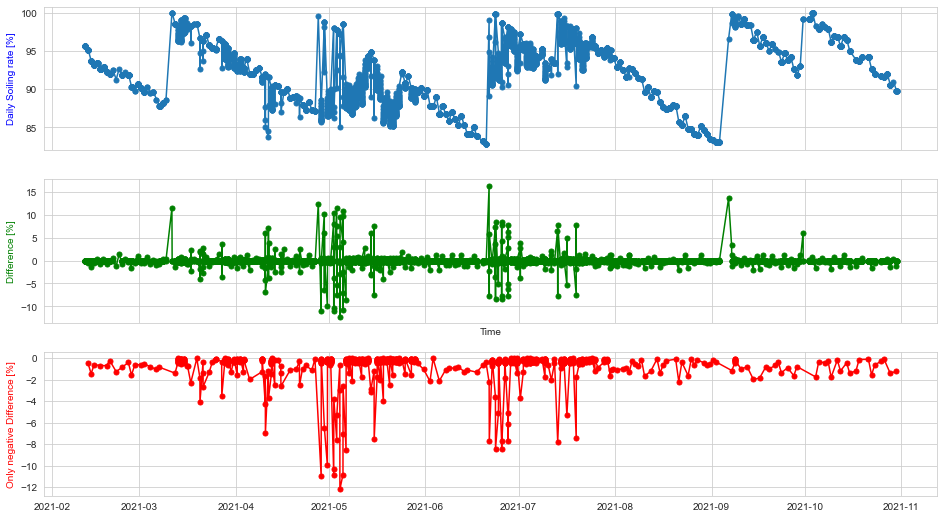

In [9]:
rate = df_rate.S_ratio.copy() * 100
dif_rate = rate.diff().round(2)
neg_dif_rate = dif_rate[dif_rate<0.0]
fig, axs = plt.subplots(3,1,figsize=(16,9), sharex=True)
axs[0].plot(rate.index, rate, marker = '.', markersize = 10)
axs[1].plot(rate.index, dif_rate, marker = '.', markersize = 10, color='green')
axs[2].plot(neg_dif_rate.index, neg_dif_rate, marker = '.', markersize = 10, color='red')
axs[1].set_xlabel('Time')
axs[0].set_ylabel(f'Daily Soiling rate [%]', color='b')
axs[1].set_ylabel(f'Difference [%]', color='green')
axs[2].set_ylabel(f'Only negative Difference [%]', color='red')

Histogram

In [10]:
# Average daily soiling rate in a year
# Calculate the IQR
Q1 = neg_dif_rate.quantile(0.05)
Q3 = neg_dif_rate.quantile(0.95)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_data = neg_dif_rate[(neg_dif_rate >= lower_bound) & (neg_dif_rate <= upper_bound)]
quant_values= abs(filtered_data)
mean_sr = quant_values.mean()
# Plot
fig = px.histogram(quant_values)
fig.add_vline(x=mean_sr, line_color='red', name='mean')
fig.show()

In [11]:
print('The red vertical line indicates the yearly soiling rate: %.2f [%%/year]' %mean_sr)

The red vertical line indicates the yearly soiling rate: 0.45 [%/year]


Additional filters and statistical analysis can be perform to make this model more robust.

### B. Uncertainty in the measured module soiling rate (%/day) --- also a single value!

We can calculate the uncertainty with unsing CI values. In this case, I have picked 95% CI (Values below). In general, we can represent uncertainty as:

**Lower Uncertainty limit < Mean value < Upper Unvertainty Level**


In [12]:
# Calculate the confidence interval
confidence_level = 0.95  
data_array = quant_values.values
n = len(data_array)
mean = np.mean(data_array)
std_dev = np.std(data_array)

# Calculate the standard error
standard_error = std_dev / np.sqrt(n)

# Calculate the margin of error
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # For a 95% CI
margin_of_error = z_score * standard_error

# Calculate the lower and upper bounds of the confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print("Mean: %.2f " %mean)
print("Standard Error: %.2f " %standard_error)
print(f"{confidence_level * 100} %% Confidence Interval: %.2f, %.2f " %(lower_bound, upper_bound))

Mean: 0.45 
Standard Error: 0.02 
95.0 % Confidence Interval: 0.40, 0.50 


The red line represents the Mean value and the blue lines represent the upper and lower limits.

In [13]:
# Plot
fig = px.histogram(quant_values)
fig.add_vline(x=mean_sr, line_color='red', name='mean')
fig.add_vline(x=lower_bound, line_color='blue', name='Lower limit')
fig.add_vline(x=upper_bound, line_color='blue', name='Upper limit')
fig.show()

### B. Lost energy due to soiling (kWh)

To answer this question we have to do the following:

1. Calculate total energy produced
2. Some assumptions should be made, in order to accelerate the process we can do it as:

**Total Energy Loss = Energy Generated - Energy with Soiling**

*Energy Generated*: Total energy that the system would have generated without any soiling.

*Energy with Soiling*: To calculate the energy generated with soiling, I use the daily soiling rate of 0.45%. The formula is:

**Energy with Soiling = Energy Generated * (1 - Soiling Rate)**


**NOTE**: This calculation can be optimized by considering only the days between rain events with high daily soiling rate.

Get *Energy Generated* from AC_Power_exp column.

In [14]:
# Calculate time intervals (in hours)
time_difference = (data_df.index[1] - data_df.index[0]).total_seconds() / 3600  # Time difference in hours
# AC_Power_exp in W
energy_generated = (data_df['AC_Power_exp'] * time_difference).sum() / 1000  # Convert to kWh

print("Total Energy Produced %.2f [kWh]:" % energy_generated)

Total Energy Produced 152456.98 [kWh]:


Get *Energy with Soiling* from AC_Power_exp column and the Total Energy loss due to soiling.

In [15]:
# Calculate energy loss due to soiling
energy_with_soiling = energy_generated * (1 - mean/100)
energy_loss = energy_generated - energy_with_soiling

print("Total Energy Loss %.2f [kWh]:" %energy_loss)
print("Total Energy Loss %.2f [%%]:" %((energy_loss/energy_generated)*100))

Total Energy Loss 681.97 [kWh]:
Total Energy Loss 0.45 [%]:


### B. Non-rain wash event date (there is only one!)

When we compared the rain events VS the soiling rate, it is quite easy to detect that right after a rain even the soiling rate effect goes to zero (back to 1). Therefore, from the plot below we can infer that that non-rain wash event is indicated by the gray shaded area.

Non-rain wash event between:

    *start_date = "2021-09-05"*
    *end_date = "2021-09-08"*

Text(0, 0.5, 'Rain [mm]')

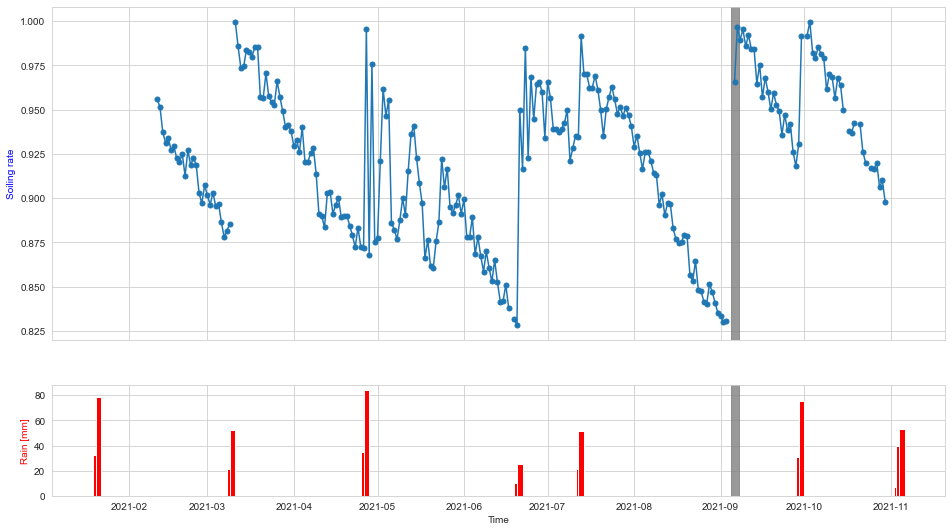

In [16]:
daily_rate = soiling.calculate_daily_soiling_rate(df_rate)
daily_rain = data_df.rain_mm.resample('D').mean()
daily_rain = daily_rain[daily_rain>0]
x = daily_rate.index
x2 = daily_rain.index
fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
axs[0].plot(x, daily_rate.S_ratio, marker = '.', markersize = 10)
axs[1].bar(x=x2, height=daily_rain, color='red', width=2)
# Add a vertical shaded area
shaded_start_date = "2021-09-05"
shaded_end_date = "2021-09-08"
# Convert the date strings to datetime objects
shaded_start_date = datetime.strptime(shaded_start_date, '%Y-%m-%d')
shaded_end_date = datetime.strptime(shaded_end_date, '%Y-%m-%d')
axs[0].axvspan(shaded_start_date, shaded_end_date, alpha=0.8, color='gray')
axs[1].axvspan(shaded_start_date, shaded_end_date, alpha=0.8, color='gray')

axs[1].set_xlabel('Time')
axs[0].set_ylabel('Soiling rate', color='b')
axs[1].set_ylabel('Rain [mm]', color='red')

# BONUS: Where in the world is this module located? (Only address this question if you’ve provided valid answers for #1-4)

From the timestamps we can see "-07:00":

"-07:00" represents the time zone offset. In this case, it's a time zone offset of 7 hours UTC Time. 
The negative sign ("-") indicates that the time is behind UTC, which means it's in a time zone west of the UTC.
So, "-07:00" indicates a time often referred to as Mountain Standard Time (MST) during standard time and Mountain Daylight Time (MDT). Therefore, the PV system can be located in Mountain Standard Time (MST) in North America (in green in the image below):


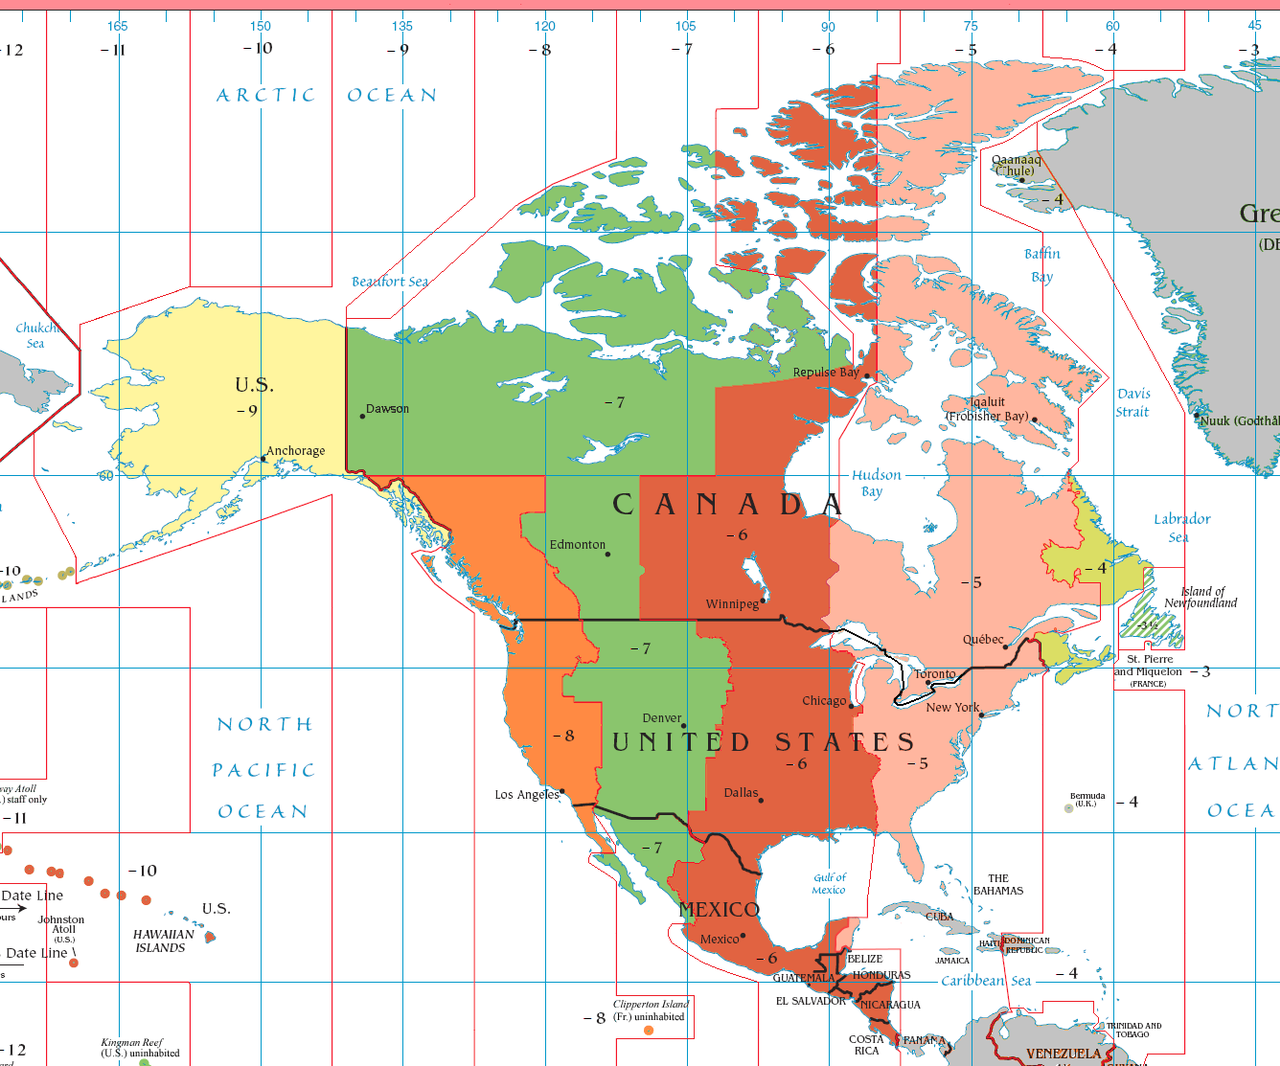